<a href="https://colab.research.google.com/github/kmkkkp/2023_2_mogakso/blob/main/EP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자율주행 환경인식

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from EP import *

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 데이터 로딩

In [ ]:
dataset_handler = DatasetHandler()

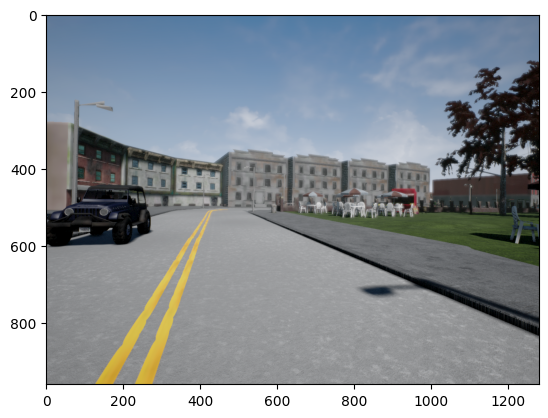

In [ ]:
image = dataset_handler.image
plt.imshow(image)

In [ ]:
k = dataset_handler.k
print(k)

[[640   0 640]
 [  0 640 480]
 [  0   0   1]]


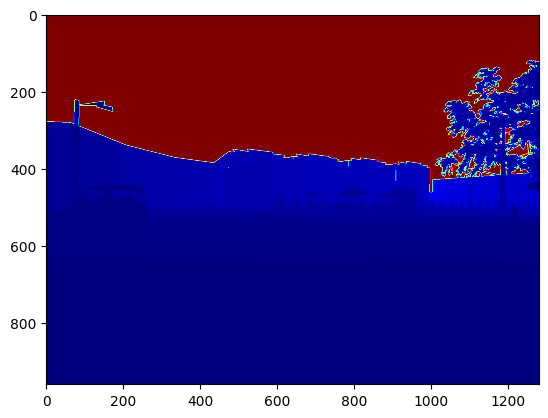

In [ ]:
depth = dataset_handler.depth
plt.imshow(depth, cmap = 'jet')

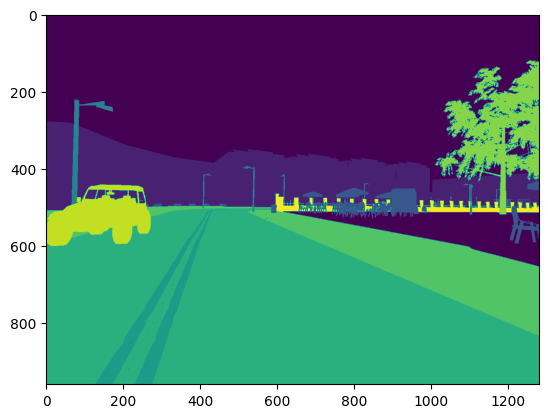

In [ ]:
segmentation = dataset_handler.segmentation
plt.imshow(segmentation)

## Segmentation Category Mapping
|Category |Mapping Index| Visualization Color|
| --- | --- | --- |
| Background | 0 | Black |
| Buildings | 1 | Red |
| Pedestrians | 4 | Teal |
| Poles | 5 | White |
| Lane Markings | 6| Purple |
| Roads | 7 | Blue |
| Side Walks| 8 | Yellow |
| Vehicles| 10 | Green |

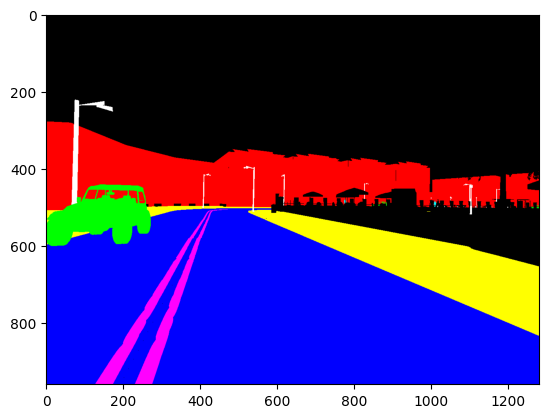

In [ ]:
colored_segmentation = dataset_handler.vis_segmentation(segmentation)
plt.imshow(colored_segmentation)

## 주행가능영역 추정


$$z = depth $$

$$x = \frac{(u - c_u) * z}{f} \tag{1}$$

$$y = \frac{(v - c_v) * z}{f} \tag{2}$$


$$K = \begin{pmatrix} f & 0 & u_c \\ 0 & f & u_v \\ 0& 0 & 1 \end{pmatrix}$$

In [ ]:
def xy_from_depth(depth, k):

    H, W = depth.shape

    f, u, v = k[0,0], k[0,2], k [1,2]

    x = np.zeros((H, W))
    y = np.zeros((H, W))

    for i in range(H):
        for j in range(W):
            x[i][j] = depth[i][j]*(j-u)/f
            y[i][j] = depth[i][j]*(i-v)/f


    return x, y

In [ ]:
k = dataset_handler.k

z = dataset_handler.depth

x, y = xy_from_depth(z, k)

In [ ]:
print('x[800,800] = ' + str(x[800, 800]))
print('y[800,800] = ' + str(y[800, 800]))
print('z[800,800] = ' + str(z[800, 800]) + '\n')

print('x[500,500] = ' + str(x[500, 500]))
print('y[500,500] = ' + str(y[500, 500]))
print('z[500,500] = ' + str(z[500, 500]) + '\n')

x[800,800] = 0.716
y[800,800] = 1.432
z[800,800] = 2.864

x[500,500] = -9.64315625
y[500,500] = 1.37759375
z[500,500] = 44.083



 ## RANSAC을 활용한 지표면 추정


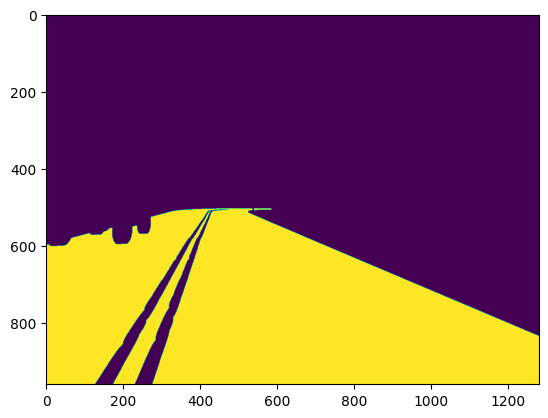

In [ ]:
road_mask = np.zeros(segmentation.shape)
road_mask[segmentation == 7] = 1

plt.imshow(road_mask)

In [ ]:
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = dataset_handler.depth[road_mask == 1]

xyz_ground = np.stack((x_ground, y_ground, z_ground))

6 Steps to apply RANSAC
1. 임의로 최소 3개의 점을 선택한다.
2. compute_plane 함수를 사용하여 접지면 모델을 계산한다.
3. 지면 모델 -> xyz_ground의 모든 지점까지의 거리 계산. -> 거리 임계값을 기준으로 inliers 계산.
4. 현재 인라이어 수가 이전의 모든 set 보다 큰지 확인하고 포인트 수가 가장 많은 인라이어 세트 유지.
5. 미리 설정된 반복횟수만큼 반복한다.
6. 최종 인라이어 세트의 모든 인라이어 사용, 평면 모델 다시 계산.

In [ ]:
xyz_ground.shape

(3, 411193)

In [ ]:
def ransac_plane_fit(xyz_data):
    num_itr = 1000
    min_num_inliers = 400000
    distance_threshold = 20
    max_num_inliers = 0
    output_plane = []

    for i in range(num_itr):
        x = xyz_data[0,:]
        y = xyz_data[1,:]
        z = xyz_data[2,:]
        a = np.random.choice(x)
        b = np.random.choice(y)
        c = np.random.choice(z)
        xyz = np.vstack(([a],[b],[c]))

        p = compute_plane(xyz)

        inliers = []

        for i in range(xyz_data.shape[1]):
            d = dist_to_plane(p,x[i],y[i],z[i])
            if d < distance_threshold:
                inliers.append([x[i],y[i],z[i]])

        num_inliers = len(inliers)

        if num_inliers > max_num_inliers:
            max_num_inliers = num_inliers

        if max_num_inliers > min_num_inliers:
            break

    inliers = np.array(inliers)
    output_plane = compute_plane(inliers.T)

    return output_plane



In [ ]:
p_final = ransac_plane_fit(xyz_ground)
p_final

array([ 0.01791171, -0.99982339,  0.00568891,  1.40286741])

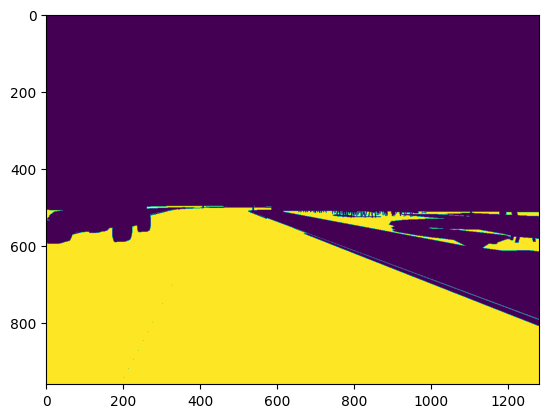

In [ ]:
dist = np.abs(dist_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)

ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0

plt.imshow(ground_mask)

c:\Users\zephyrus\Downloads\Files\Files\home\jovyan\work\module6\EP.py:226: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
c:\Users\zephyrus\Downloads\Files\Files\home\jovyan\work\module6\EP.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


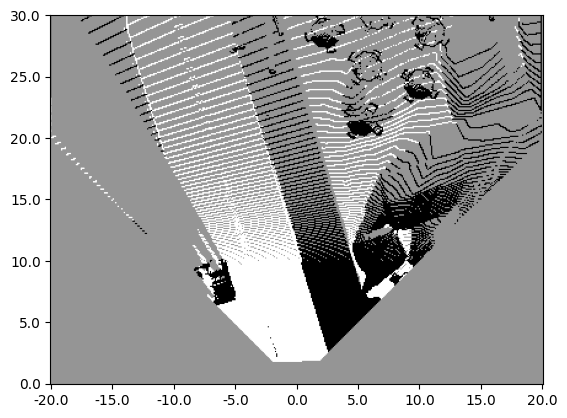

In [ ]:
dataset_handler.plot_free_space(ground_mask)

# 시맨틱 분할 출력을 활용한 차선 추정

차선추정 3단계:

1. 도로 평면에서 차선에 관련된 segmentation 픽셀을 포함하는 이미지를 생성한다.(라벨 6, 8)
2. 1에서 도출된 차선 경계 영상에서 Edge Detection을 수행한다.
3. 2에서 도출된 Edge Detection 결과물로 라인 추정을 수행한다

In [ ]:
def estimate_lane_lines(segmentation_output):
    mask = np.zeros(segmentation.shape)
    mask[segmentation == 6] =1
    mask[segmentation == 8] =1

    # edges detection
    edges = cv2.Canny((mask*255).astype(np.uint8),100, 125)

    # Line estimation
    lines = cv2.HoughLinesP(edges, 10, np.pi/180, 200, minLineLength = 150, maxLineGap = 50)
    lines = lines.reshape(lines.shape[0],4)

    return lines



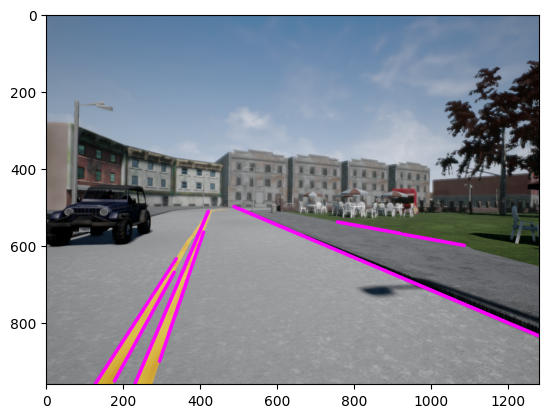

In [ ]:
lane_lines =  estimate_lane_lines(segmentation)

plt.imshow(dataset_handler.vis_lanes(lane_lines))

## 차선 병합 및 필터링

1. 차선 병합 : 유사한 기울기와 절편을 가진 라인끼리 병합
2. 수평선 필터링 : 기울기 임계값 기준 필터링

In [ ]:
def merge_lane_lines(lines):
    slope_similarity_threshold = 0.1
    intercept_similarity_threshold = 40
    min_slope_threshold = 0.3

    clusters = []
    current_inds = []
    i = 0

    slopes, intercepts = get_slope_intecept(lines)

    slopes_horizontal = np.abs(slopes)   > min_slope_threshold

    for slope,intercept in zip(slopes,intercepts):
        if not np.any([i in current for current in current_inds]):
            slope_cluster = (slopes < (slope + slope_similarity_threshold)) & (slopes > (slope -slope_similarity_threshold))
            intercept_cluster = (intercepts < (intercept +intercept_similarity_threshold)) & (intercepts > (intercept -intercept_similarity_threshold))
            inds = np.argwhere(slope_cluster & intercept_cluster & slopes_horizontal).T.flatten()
        if len(inds):
            current_inds.append(inds)
            clusters.append(lines[inds])
        i+=1

    merged_lines = [np.mean(lines[indices], axis=0) for indices in current_inds]
    merged_lines = np.array(merged_lines).reshape((-1, 4))

    return merged_lines

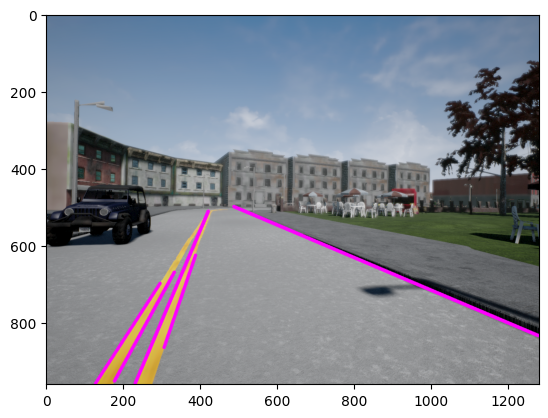

In [ ]:
merged_lane_lines = merge_lane_lines(lane_lines)
plt.imshow(dataset_handler.vis_lanes(merged_lane_lines))

In [ ]:
max_y = dataset_handler.image.shape[0]
min_y = np.min(np.argwhere(road_mask == 1)[:, 0])

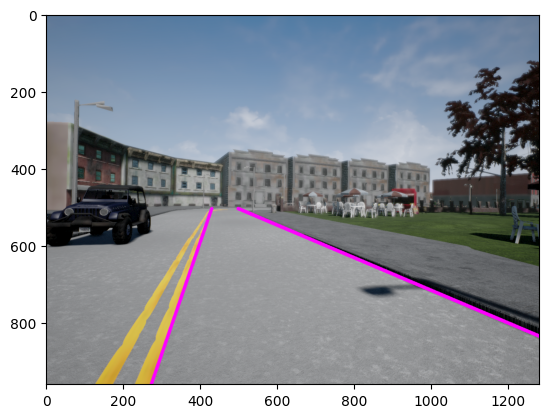

In [ ]:
extrapolated_lanes = extrapolate_lines(merged_lane_lines, max_y, min_y)
final_lanes = find_closest_lines(extrapolated_lanes, dataset_handler.lane_midpoint)
plt.imshow(dataset_handler.vis_lanes(final_lanes))


## 2D 객체 인식을 활용한 충돌 최소 거리 계산

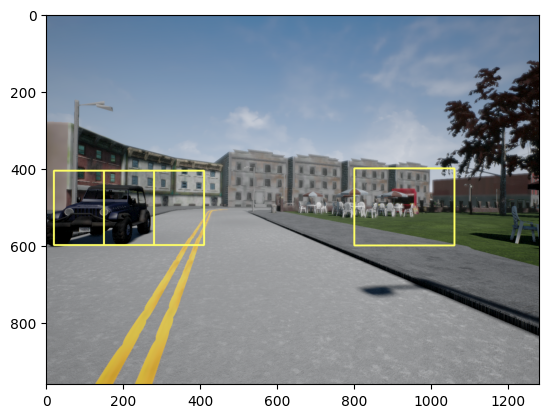

In [ ]:
detections = dataset_handler.object_detection
plt.imshow(dataset_handler.vis_object_detection(detections))

In [ ]:
print(detections)

[['Car' '20.0' '406.0' '280.0' '599.0' '0.99']
 ['Car' '150.0' '406.0' '410.0' '599.0' '0.95']
 ['Car' '800.0' '400.0' '1060.0' '600.0' '0.76']]


In [ ]:
def filter_detections_by_segmentation(detections, segmentation_output):
    ratio_threshold = 0.3
    filtered_detections = []


    for detection in detections:
        Class, x_min, y_min, x_max, y_max, score = detection
        y_min = int(float(y_min))
        y_max = int(float(y_max))
        x_min = int(float(x_min))
        x_max = int(float(x_max))

        area_box = (x_max-x_min) * (y_max-y_min)

        if Class == 'Car':
            cat = 10
        elif Class == 'Pedestrian':
            cat = 4

        correct_pixels = (segmentation_output[y_min:y_max, x_min:x_max] == cat).sum()
        ratio = correct_pixels/area_box

        if ratio > ratio_threshold:
            filtered_detections.append(detection)


    return filtered_detections

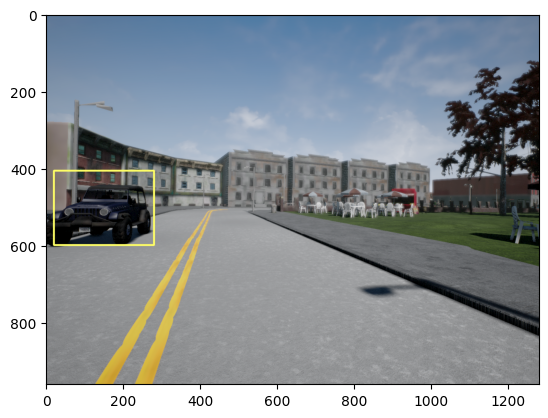

In [ ]:
filtered_detections = filter_detections_by_segmentation(detections, segmentation)

plt.imshow(dataset_handler.vis_object_detection(filtered_detections))

In [ ]:
def find_min_distance_to_detection(detections, x, y, z):

    min_distances = []
    for detection in detections:
        Class, x_min,y_min,x_max,y_max, score = detection
        y_min = int(float(y_min))
        y_max = int(float(y_max))
        x_min = int(float(x_min))
        x_max = int(float(x_max))

        box_x = x[y_min:y_max, x_min:x_max]
        box_y = y[y_min:y_max, x_min:x_max]
        box_z = z[y_min:y_max, x_min:x_max]

        dist = np.sqrt(box_x**2 + box_y**2 + box_z**2)
        min_distances.append(np.min(dist))

    return min_distances



In [ ]:
min_distances = find_min_distance_to_detection(filtered_detections, x, y, z)
print(min_distances)

[8.517358087690415]


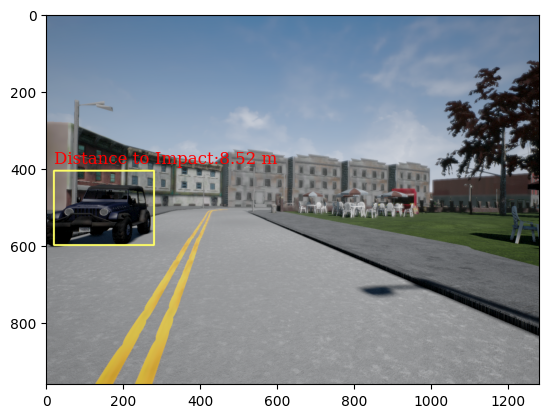

In [ ]:
font = {'family': 'serif','color': 'red','weight': 'normal','size': 12}

im_out = dataset_handler.vis_object_detection(filtered_detections)

for detection, min_distance in zip(filtered_detections, min_distances):
    bounding_box = np.asfarray(detection[1:5])
    plt.text(bounding_box[0], bounding_box[1] - 20, 'Distance to Impact:' + str(np.round(min_distance, 2)) + ' m', fontdict=font)

plt.imshow(im_out)